# RECTANGULAR AGGREGATIONS


Python code and examples for the algorithms developed in [arXiv:1707.05783 [hep-ph]](http://arxiv.org/abs/arXiv:1707.05783). If you find this code useful please cite the original paper:

P. Asadi, M. R. Buckley, A. DiFranzo, A. Monteux and D. Shih,  
_Digging Deeper for New Physics in the LHC Data_  
JHEP **1711**, 194 (2017) [doi:10.1007/JHEP11(2017)194](https://doi.org/10.1007/JHEP11%282017%29194)  

### required packages
The code was written in `python 2.7`. Porting to `python 3` would be relatively easy  
In this notebook, and in the helper files, we use the following python packages (all can be installed with `pip install`)
* `joblib` for parallel processing. On a recent laptop (2016 MacBook Air), one can speed up the computation by running at least 4 jobs at a time.
* `interval` for easy definitions of open and closed intervals for kinematic variables

For computing the statistical significance of a signal region or a rectangular aggregation, we use:
* `iminuit` to numerically minimize the likelihood with respect to the nuisance parameters
* `cython` to efficiently speed the computation, by translating the python code into C and then compiling it

Finally, we use standard python packages such as `numpy`, `matplotlib`, `scipy.linalg`, `math` and `itertools`

##### easy setup
Create an Anaconda environment with all the required packages:

    conda create --name LHCra python=2.7 pip  
    source activate LHCra
    pip install numpy matplotlib joblib interval iminuit cython scipy
    jupyter notebook

You can verify that Jupyter is seeing the right environment (`LHCra` if you executed the lines above) by executing the following line in a cell

    %%bash
    conda env list

# Table of contents
* [load definitions](#definitions)
* [Rectangular Aggregations](#aggregation)
* [Compute Significance](#significance)
* [Visualize parameter space, signal regions and hot spots](#visualize)
* [Miscellanous](#misc)

## load definitions that will be used below  <a class="anchor" id="definitions"></a>

In [2]:
def parallel_run_RA(i, start_time, print_flag=False):
    """Find bins overlapping with i-th rectangle"""
    # every 10k rectangles, output status
    if print_flag and i%10000==0:
        current_time = (time.time()-start_time)
        out=''
        out = sec_to_hms(current_time)+" passed, "+sec_to_hms(1.0*(len(allRAs)-i)/len(allRAs)*tot_time)+" remaining..."
        print i,'/',len(all_rectangles), "... "+out
    RA = ra.makeRA(all_rectangles[i])
    return RA


def run_all_RA(all_rectangles, N_PARALLEL_JOBS=4, print_flag=False):
    """Parallel run to find all aggregations given a list of rectangle definitions"""
    # first make a small run of first 1k rectangles to estimate how long it will take
    start = time.time()
    n_batch =1000
    RAlist0 = Parallel(n_jobs = N_PARALLEL_JOBS)(delayed(parallel_run_RA)(i, start, print_flag) for i in range(0,len(all_rectangles[:n_batch])))
    tot_time = (time.time()-start)*(len(all_rectangles))/n_batch
    print "estimated total time = "+ra.sec_to_hms(tot_time)+'...',
    # then run the rest of the rectangles
    RAlist0 = RAlist0 + Parallel(n_jobs = N_PARALLEL_JOBS)(delayed(parallel_run_RA)(i, start, print_flag) for i in range(n_batch,len(all_rectangles)))
    print 'Done!'.rjust(10)
    return RAlist0

def unique(mylist, flag_print=True):
    """delete duplicates from aggregation list"""
    res=[]
    for el in mylist:
        if len(el)>0 and el not in res: res.append(el)
    if flag_print: print 'Found '+str(len(res))+' individual aggregations.'
    return res

In [3]:
def parallel_q0_func(aggregation_list, i):
    """Calls function to compute significance for i-th rectangle in list"""
    SR_list = aggregation_list[i]
    return find_q0_ASR(SR_list)

def find_q0_ASR(SR_list):
    '''Compute test statistic q0 for a given aggregation'''
    #if flag_out: print 'ASR #'+str(i)+':', SR_list
    
    # define new observed/background vectors, where the first bin has been aggregated
    [new_obs, new_back, newV ] =  q0.aggregate(SR_list)
    new_sig = [0] * len(new_obs)
    # new physics always adds events, but here we also look at deficits, so it could be <0
    # signal events in ASR: this is a first guess (obs-bg), the cross section multiplier is variable in the minimization
    new_sig[0] = (new_obs[0] - new_back[0])
    q0.setSig(np.array(new_sig))
    
    # minimize log-likelihood for mu=0 (SM) and variable mu (signal)
    [ muhat, LLhat, theta_vec_hat, postfit_err_vec_hat ] = q0.runmin_err(1.0,False)
    [ mu0, LL_0, theta_vec_0, postfit_err_vec_0 ] = q0.runmin_err(0.0,True)
    
    # the global minimum cannot be lower than the SM minimum: sometimes minuit gets stuck, usually at large values of signal counts
    # recompute up to 10 times rescaling down signal, otherwise give up :(
    mutry, n_try = 1., 0
    while ( LLhat > LL_0 + 0.01 and n_try < 10):
        n_try += 1
        mutry = mutry/n_try
        [ muhat, LLhat, theta_vec_hat, postfit_err_vec_hat ] = q0.runmin_err(mutry,False)

    return [SR_list, [muhat, muhat * new_sig[0], LL_0, LLhat, theta_vec_hat[0], postfit_err_vec_hat[0]]]

def run_all_q0_RA(aggregation_list, N_PARALLEL_JOBS=4):
    """Parallel run to find log-likelihood of many rectangular aggregations"""
    # first make a small run of first 100 rectangles to estimate how long it will take
    start = time.time()
    n_batch = 100
    N_PARALLEL_JOBS = min(N_PARALLEL_JOBS, len(aggregation_list))
    res_q0 = Parallel(n_jobs = N_PARALLEL_JOBS)(delayed(parallel_q0_func)(aggregation_list, i) for i in range(0,len(aggregation_list[:n_batch])))
    tot_time = (time.time()-start)*(len(aggregation_list))/n_batch
    print "estimated total time = "+ra.sec_to_hms(tot_time)+'...',
    # then run the rest of the rectangles
    res_q0 += Parallel(n_jobs = N_PARALLEL_JOBS)(delayed(parallel_q0_func)(aggregation_list, i) for i in range(n_batch,len(aggregation_list)))
    print 'Done!'.rjust(10)
    return res_q0

# from the log-likelihood, get the number of sigmas (with sign)
def findsigmaq0_signed(sighat,LLhat,LL0):
    '''From the log-likelihood, yield the number of sigmas (with sign)'''
    sign = (1) if sighat >0 else (-1)
    deltaLL = LL0-LLhat
    # if delta LL<0 it means it did not find the minimum. Return a defaul of 99
    # (filter those when using results)
    Nsigma=99 if deltaLL < 0 else np.sqrt(deltaLL)
    return [sighat, sign * Nsigma ]

# Run rectangular aggregation <a class="anchor" id="aggregation"></a>

Each bin is defined by a given range for each kinematic variable.  
The input of our algorithm is a text file which defines the geometry of the parameter space. For the search used as an example in this notebook, the kinematic variables are missing energy $E_T^{miss}$, scalar sum of jet transverse momentum $H_T$, and jet and b-jet multiplicities $N_j$ and $N_b$. For each bin, the input file will have the *lower and upper delimiters* in each kinematic variable.  
For example, the first five bins of this search are listed in the .dat file as (each entry is tab-delimited):

```
Bin  MET	MET	HT     HT     Nj   Nj   Nb   Bkg   bg_err_stat+ bg_err_sys+ bg_err_stat- bg_err_sys-  Data
1	300	350	300	500	2	2	0	20370   120		 980		 120	       960		21626
2	300	350	500	1000   2	2	0	1541	37	 	 82		  37	        79	     1583
3	300	350	1000   Inf.   2	2	0	76.3	9.1	 	5.5		 8.2	       5.	     102
4	350	500	350	500    2	2	0	13076   93	 	 630	 	93	        620	    14019
5	350	500	500	1000   2	2	0	3615	49	 	 180	 	49	        170	    3730
```
For clarity, this can be repackaged as a table:

|Bin|MET|MET|HT|HT|Nj|Nj|Nb|Bkg|bg_err_stat+|bg_err_sys+|bg_err_stat-|bg_err_sys-|Data|
|---|---|---|---|---|---|---|---|---|---|---|---|---
|1|300|350|300|500|2|2|0|20370|120|980|120|960|21626|
|2|300|350|500|1000|2|2|0|1541|37|82|37|79|1583|
|3|300|350|1000|Inf.|2|2|0|76.3|9.1|5.5|8.2|5.|102|
|4|350|500|350|500|2|2|0|13076|93|630|93|620|14019|
|5|350|500|500|1000|2|2|0|3615|49|180|49|170|3730|

Note that for each bin, we have also listed the background predictions with statistical and systematic errors (which could be asymmetric), as well as the observed event counts. This info is also loaded. For the errors, we sum in quadrature statistical and systematic errors, and in presence of asymmetric errors we take the largest as a conservative estimate (instead of having double-sided gaussians).

For each search, the information can be extracted from tables in the paper, and in some cases from code/root files made available by the experimental collaborations.  
When available, the covariance matrix between backgrounds in different bins is used (from CMS only so far. Thanks CMS!).

The code first reads the first line to understand which kinematic variables are being used, which it then puts into a list, `kin_vars`. It stops when it reads the block named `Bkg`. Also, the `Bin` column is not actually used, and it numbers bins in the order they are in the list.

If a variable name appears twice, it is understood that the two columns are specifying a range, with the first column giving the lower limit and the second column giving the upper limit in that same variable. If a variable name appears only once (e.g. `Nb` above), we assume that the bin is defined by a single value of that variable (e.g. $N_b=0,1,2\ldots$ above). The same result could have been achieved by repeating a colum twice, in which case the code would have recognized that lower limit = upper limit.  

**N.B.** A distinction has to be made between variables that are integers and those that are non-integers, which will be important when deciding if a bin is included in a range for a variable. Clearly, variables counting the number of jets, leptons and so on are always integers.
**It is currently assumed that any variable that starts with an `N` is counting an integer variable**. This is then set in a list.  
**Be aware if using this code for a different search, and add a line of code in the function `reorder_vars(kv)` in [RA_functions.py](RA_functions.py) if there are other kinematic variables with names starting with `N`**.

For (arbitrary) aestethical purposes, we use the same function to re-order the variables such that all integer variables appear first in the list of variables. For example, for the search specified above, we will get a list of variables in this order:
$$
N_j,\ N_b,\ H_T,\ E_T^{miss}
$$

Then, the code runs through each successive line of the .dat file and creates two python dictionaries which for each bin assign a lower and upper limit for each bin, `var_min`, `var_max`; e.g. the first 5 entries for var_min are

({1: {'HT': '300', 'MET': '300', 'Nb': '0', 'Nj': '2'},
  2: {'HT': '500', 'MET': '300', 'Nb': '0', 'Nj': '2'},
  3: {'HT': '1000', 'MET': '300', 'Nb': '0', 'Nj': '2'},
  4: {'HT': '350', 'MET': '350', 'Nb': '0', 'Nj': '2'},
  5: {'HT': '500', 'MET': '350', 'Nb': '0', 'Nj': '2'},...)

From this, we generate `dictionary`, which for each bin gives the lower/upper range in each kinematic variable as a tuple *(min, max)*. This also translates the overflow bin keyword `Inf.` into a very large number ($99999.$)  
{1: {'HT': (300.0, 500.0),
  'MET': (300.0, 350.0),
  'Nb': (0.0, 0.0),
  'Nj': (2.0, 2.0)},
 2: {'HT': (500.0, 1000.0),
  'MET': (300.0, 350.0),
  'Nb': (0.0, 0.0),
  'Nj': (2.0, 2.0)},
 3: {'HT': (1000.0, 99999.0),
  'MET': (300.0, 350.0),
  'Nb': (0.0, 0.0),
  'Nj': (2.0, 2.0)},
 4: {'HT': (350.0, 500.0),
  'MET': (350.0, 500.0),
  'Nb': (0.0, 0.0),
  'Nj': (2.0, 2.0)},
 5: {'HT': (500.0, 1000.0),
  'MET': (350.0, 500.0),
  'Nb': (0.0, 0.0),
  'Nj': (2.0, 2.0)}, ... )

In [4]:
import time, sys, os
import numpy as np
from joblib import Parallel, delayed # for parallel processing
import matplotlib.pyplot as plt

In [32]:
import RA_functions as ra

In [6]:
# SEARCH = 'CMS033_allSRs'
SEARCH = 'CMS036'

In [8]:
# input_file = 'in/CMS033_allSRs.dat'
input_file = 'in/CMS036.dat'
[binlist, obs_vec, bg_vec, bg_err_vec, kin_vars, kin_map, var_min, var_max] = ra.read_SR_defs(input_file)


Running rectangular aggregation algorithm on given input...
Recognized kinematic variables: ['Nj', 'Nb', 'HT', 'MT2']
Mapping between variable and column in data file: {'MT2': [6, 7], 'Nj': [3, 4], 'Nb': [5], 'HT': [1, 2]}


We also imported the event counts (observed, background with relative errors) from the input file.

In [9]:
dictionary = {}
for Bin in binlist:
    dictionary[Bin] = {}
    for var in kin_vars:
        dictionary[Bin][var]=(ra.getn(var_min[Bin][var]), ra.getn(var_max[Bin][var]))

# dictionary

For each kinematic variable, make a list of all the delimiters in that direction. Then in each direction take combinations of 2 delimiters at a time, which will be the basis for all possible (hyper-)rectangles

In [10]:
allbins_separators = [ [var, sorted(list(set([ (var_min[bin][var]) for bin in binlist])),key=ra.getn)+['Inf.']] for var in kin_vars ]
allbins_separators

[['Nj', ['1', '2', '4', '7', 'Inf.']],
 ['Nb', ['0', '1', '2', '3', 'Inf.']],
 ['HT', ['250', '350', '450', '575', '700', '1000', '1200', '1500', 'Inf.']],
 ['MT2',
  ['0',
   '200',
   '300',
   '400',
   '500',
   '600',
   '800',
   '1000',
   '1200',
   '1400',
   'Inf.']]]

In [67]:
print "Will make hyper-rectangles by taking all possible combinations given these bin ranges:"
print 'KV \t # of bins\t ranges'
for varbin in allbins_separators:
    print varbin[0],':\t', len(ra.varbins(varbin[0])),'\t\t',ra.varbins(varbin[0])

Will make hyper-rectangles by taking all possible combinations given these bin ranges:
KV 	 # of bins	 ranges
Nj :	15 		[['2', '2'], ['2', '4'], ['2', '6'], ['2', '8'], ['2', 'Inf.'], ['3', '4'], ['3', '6'], ['3', '8'], ['3', 'Inf.'], ['5', '6'], ['5', '8'], ['5', 'Inf.'], ['7', '8'], ['7', 'Inf.'], ['9', 'Inf.']]
Nb :	10 		[['0', '0'], ['0', '1'], ['0', '2'], ['0', '3'], ['1', '1'], ['1', '2'], ['1', '3'], ['2', '2'], ['2', '3'], ['3', '3']]
HT :	21 		[['300', '350'], ['300', '500'], ['300', '750'], ['300', '1000'], ['300', '1500'], ['300', 'Inf.'], ['350', '500'], ['350', '750'], ['350', '1000'], ['350', '1500'], ['350', 'Inf.'], ['500', '750'], ['500', '1000'], ['500', '1500'], ['500', 'Inf.'], ['750', '1000'], ['750', '1500'], ['750', 'Inf.'], ['1000', '1500'], ['1000', 'Inf.'], ['1500', 'Inf.']]
MET :	10 		[['300', '350'], ['300', '500'], ['300', '750'], ['300', 'Inf.'], ['350', '500'], ['350', '750'], ['350', 'Inf.'], ['500', '750'], ['500', 'Inf.'], ['750', 'Inf.']]


We now have everything we need to generate all rectangles. Given a $d$-dimensional grid, with $n_{i}$ bin separators in each directions, the total number of possible rectangle is
$$
\prod_{i=1}^d  {n_{i}\choose 2}
$$
For each rectangle in this $d$-dimensional space, we want the bins that fall inside of it.
Multiple of these rectangles will contain the same bins (or sometimes no bins at all), so we will have to delete duplicates from the RA list.

In [10]:
all_rectangles = ra.recursive_RA_loop([],kin_vars)
print "There are",len(all_rectangles), " distinct rectangle definitions, including repeated SR aggregations."

There are 31500  distinct rectangle definitions, including repeated SR aggregations.


In [15]:
RAlist0 = run_all_RA(all_rectangles,4)

estimated total time = 6m41s...      Done!


In [16]:
RAlist = unique(RAlist0)

Found 7492 individual aggregations.


This aggregation list covers all possible combinations of signal regions, starting from the usual individual bins to a super-bin that aggregates *all* the bins into one.  
For example one can plot a histogram of the number of bins in each aggregation

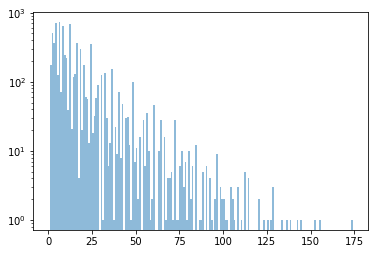

In [18]:
_ = plt.hist(map(len,RAlist), bins=range(0,max(map(len,RAlist))+1), log=True, alpha=0.5)
# plt.xscale('log')

#### save RA list

In [13]:
outfilename = os.path.join('out',os.path.basename(input_file).split('_')[0]+'_RAs.dat')

In [21]:
with open(outfilename,'w') as outfile:
    outfile.write(str(RAlist))
    print 'saved to '+outfilename

saved to out/CMS033_RAs.dat


#### load saved RA list

In [11]:
import ast # for easy parsing of SR list from command line

In [13]:
infilename = os.path.join('out',os.path.basename(input_file).split('_')[0]+'_RAs.dat')
if os.path.isfile(infilename):
    with open(infilename,'r') as infile:
        RAlist = ast.literal_eval(infile.readlines()[0])


# Find significance of rectangles <a class="anchor" id="significance"></a>

For each SR or rectangular_aggregation, we want to be able to calculate if there is an excess with respect to the Standard Model. The likelihood function is a Poisson likelihood for observed counts, times a Gaussian term for the nuisance parameters representing background uncertainties.
$$
\mathcal{L(\mu,\vec\theta)}=\prod_i \frac{(\mu s_i+b_i+\theta_i)^{n_i}e^{-(\mu s_i+b_i+\theta_i)}}{n_i!}\rm{exp}\left(-\frac12\vec\theta^T V^{-1}\vec\theta\right)
$$
Here the product is over the different bins $i$, for each of which we have:
+ $n_i$, the number of observed events
+ $b_i$, the expected background events
+ $\theta_i$, the uncertainty in the background, with a covariance matrix $V_{ij}$ between bins $i$ and $j$
+ $s_i$, the BSM signal hypothesis for a given BSM cross section

The parameter $\mu$ is a cross section multiplier for the BSM signal ($\mu=0$ corresponds to the SM). For each value of $\mu$, one can maximize $\mathcal{L}$ with respect to the nuisance parameters $\vec\theta$. 

Then, one can define a test statistic $q(\mu) = -2 \log \frac{\mathcal{L}(\mu,\hat\theta_\mu)}{\mathcal{L}(\hat\mu,\hat\theta_{\hat\mu})}$, where the denominator is the global maximum of $\mathcal{L}$. This is a nice quantity because  (in the large $N$ limit...) $q_0$ is distributed as $\chi^2$ test statistic with one degree of freedom. For example, when $q(\mu)=4$, the hypotesis $\mu$ is excluded at 2$\sigma$, or at the 95% CL. Said otherwise, when comparing the hypothesis $\mu$ and the "best-fit" hypothesis $\hat\mu$, the data is better explained by the best-fit hypothesis, and one can exclude the *null hypothesis* $\mu$.

** Here we want to find an excess with respect to the Standard Model, which is therefore the null hypothesis** ($\mu=0$, e.g. no BSM signal).   
We use the test statistics $q_0$, for which we see if the data is better explained by some New Physics than it is by the Standard Model. Many NP signal hypothesis can be tested, which yield different signal distribution $s_i$. The (local) significance of an excess is defined as the (local) *p*-value for the null hypothesis (SM) given the signal hypothesis, and can be expressed in terms of $\sigma$ as $N_\sigma=\sqrt{q_0}$ (in the asymptotic limit).

For more details, see for example:  
[Cowan, Kramer, Gross, Vitells, "Asymptotic formulae for likelihood-based tests of new physics" arXiv:1007.1727](https://arxiv.org/abs/1007.1727)

First we need to import functions that calculate log-likelihood test ratio for a given search. Because we use `cython`, we need to compile the python code to get a shared library that we will call functions from.  
**NB: it should be re-compiled every time the source *q0_functions.pyx* is modified**

In [161]:
%%bash
echo "Compiling the python code into C with cython..."
python cython_setup.py build_ext --inplace

Compiling the python code into C with cython...
Compiling q0_functions.pyx because it changed.
[1/1] Cythonizing q0_functions.pyx
running build_ext
building 'q0_functions' extension
gcc -fno-strict-aliasing -I/Users/dio/anaconda/include -arch x86_64 -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/dio/anaconda/lib/python2.7/site-packages/numpy/core/include -I/Users/dio/anaconda/include/python2.7 -c q0_functions.c -o build/temp.macosx-10.6-x86_64-2.7/q0_functions.o
gcc -bundle -undefined dynamic_lookup -L/Users/dio/anaconda/lib -arch x86_64 -arch x86_64 build/temp.macosx-10.6-x86_64-2.7/q0_functions.o -L/Users/dio/anaconda/lib -o /Users/dio/git/RA_python/q0_functions.so


In file included from q0_functions.c:579:
In file included from /Users/dio/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/dio/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:17:
In file included from /Users/dio/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1761:
/Users/dio/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: "Using deprecated NumPy API, disable it by "          "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it by " \
 ^
1 warning generated.


In [12]:
import q0_functions as q0

We already have the event counts from reading the input (.dat) file earlier. We load them into global variables that the cythonized code uses.  
Note that the covariance matrix is loaded separately, by pointing to a different .dat file (which was exported from root files provided by CMS). In the case that no covariance is provided (e.g. ATLAS), the covariance matrix is simply constructed from the background error vector, $V=diag((\delta b_i)^2)$.

In [13]:
q0.loadAllCounts(obs_vec, bg_vec, bg_err_vec);

In [14]:
q0.loadVcovar('search_data/V_'+SEARCH+'.dat')

Given the RA list defined in the previous subsection, we can now calculate the significance of each aggregation, assuming that a signal populates *only* that region of parameter space.  
**N.B. this step can take a long time for many signal regions (>>100) and with correlations. (up to many hours)**

In [11]:
%%capture --no-stdout
res_q0 = run_all_q0_RA(RAlist)

The results of the run in the variable `res_q0` are given as:  \[ $\hat\mu$, $\hat N_{signal}$, $\mathcal{\hat L}_{\mu=0}$, $\mathcal{\hat L}_{\hat\mu}$, $\hat\theta^0_{\hat\mu}$, $\delta\hat\theta^0_{\hat\mu}$ \]  
which are respectively, 
* $\hat\mu$, the best-fit cross section multiplier
* $\hat N_{signal}$, the best-fit number of signal events in the rectangular aggregation
* $-2\log \mathcal{\hat L}_{\mu=0}$, the minimum of the log-likelihood for the SM (estimated at $\mu=0$)
* $-2\log \mathcal{\hat L}_{\hat\mu}$, the minimum of the log-likelihood for the New Physics hypothesis (leaving the number of events in the RA variable with $\mu$)
* $\hat\theta^{RA}_{\hat\mu}$, the post-fit nuisance parameter for the RA bin. The post-fit background in the first bin will then be $b_{RA}^{post-fit}=b_{RA} + \hat\theta^{RA}_{\hat\mu}$
* $\delta\hat\theta^{RA}_{\hat\mu}$, the post-fit error for the RA, $\delta b_{RA}^{post-fit}$. This is evaluated by the `iminuit` errors() function, by varying the first bin nuisance parameter until the log-likelihood is changed by 1 (correpsonding to 1 sigma)

The statistical significance of an excess in a rectangular aggregation is given by $N_\sigma=\sqrt{q_0}$. This is approximately the same as taking $(N^{obs}_{RA}-b_{RA}^{post-fit})/{\delta b_{RA}^{post-fit}}$

In [43]:
all_RAs_sigma = [[res[0],findsigmaq0_signed(res[1][1],res[1][3],res[1][2]) ] for res in res_q0 ]

In [153]:
single_bin_sigma = [ RA for RA in all_RAs_sigma if len(RA[0])==1 ]

Sometimes `Minuit` fails to find the global minimum. This is caught by outputting 99 in the q0 code.  
Usually it is a problem of starting too far from the minimum, which I try to fix by re-trying up to 10 times rescaling  the signal. It could be fixed by hand

In [51]:
all_RAs_sigma = filter(lambda x: x[1][1]!=99, all_RAs_sigma)
single_bin_sigma = filter(lambda x:  x[1][1]!=99, single_bin_sigma)

In [17]:
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
plt.rc('font', family='serif')

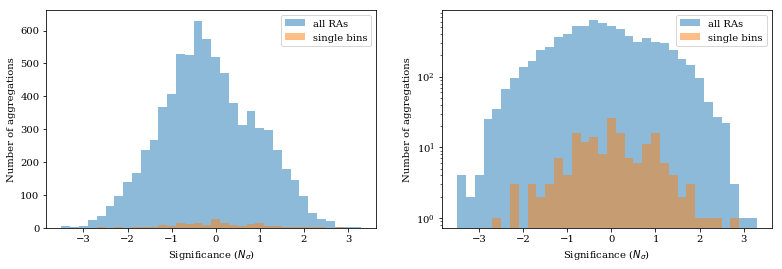

In [157]:
fig, axes = plt.subplots(1,2,figsize=(13,4))

n, bins, patch_list = axes[0].hist([out[1][1] for out in all_RAs_sigma], 
                               np.arange(-3.5,3.5,0.2),  alpha=0.5, label='all RAs')
n, bins, patch_list = axes[0].hist([out[1][1] for out in single_bin_sigma], 
                               np.arange(-3.5,3.5,0.2),  alpha=0.5, label='single bins')
n, bins, patch_list = axes[1].hist([out[1][1] for out in all_RAs_sigma],
                               np.arange(-3.5,3.5,0.2),  alpha=0.5, log=True, label='all RAs')
n, bins, patch_list = axes[1].hist([out[1][1] for out in single_bin_sigma], 
                               np.arange(-3.5,3.5,0.2),  alpha=0.5, log=True, label='single bins')
for ax in axes:
    _=ax.legend()
    _=ax.set_xlabel('Significance ($N_\sigma$)')
    _=ax.set_ylabel('Number of aggregations')

As can be seen by inspection, a lot of these excesses share a **core** of signal regions. What is happening is that there is a core of signal regions with a significant excess, on top of which one can add multiple nearby bins that have little or no excess. Increasing the size of the rectangular aggregation can then slightly increase the significance, or reduce it if the nearby bins have deficits.

Therefore, one will not want to add these additional aggregation in the list of **noteworthy excesses**, as the smaller core of the excess is already enough to warn us of its presence.
Given a set of all excesses $A$, we will populate the set of "core excesses" $B$ as:
$$
B = \{ b \in A\ |\ \ SR(b)\subseteq SR(a) \ \&\ 0.9< \frac{N_\sigma(b)}{N_\sigma(a)}<1\ \  \forall a\in A\}
$$
NB: Here we choose to drop any "overaggregation" where the significance increases by only up to 10% (hence the 0.9 factor, but note that this choice is arbitrary, and other can be considered)

In [159]:
largest_excesses1 = filter(lambda x: x[1][1]>2.5, sorted(all_RAs_sigma, key=lambda x: x[1][1], reverse=True))
largest_excesses = []
for a in largest_excesses1[:]:
    if not any([set(b[0]) < set(a[0]) and 0.9<(b[1][1]/a[1][1])<1. for b in largest_excesses1 ]): 
        largest_excesses.append(a)
largest_excesses = filter(lambda x: x[1][1]>2.57, largest_excesses)
print 'All large excesses:', len(largest_excesses1),'... Core excesses:',len(largest_excesses)
for e in largest_excesses:
    print e[0], '%.3f'% e[1][1]

All large excesses: 27 ... Core excesses: 11
[13, 16, 23, 26, 43, 46, 53, 56, 63, 66] 3.114
[1, 4, 31, 34, 71, 74] 2.962
[13, 16, 23, 26, 43, 46, 53, 56] 2.773
[126] 2.731
[71, 74, 81, 84] 2.697
[13, 16, 43, 46, 83, 86, 120, 122] 2.653
[1, 4, 31, 34] 2.645
[21, 22, 23, 24, 25, 26, 51, 52, 53, 54, 55, 56, 61, 62, 63, 64, 65, 66] 2.645
[13, 16, 23, 26, 43, 46, 53, 56, 83, 86, 93, 96, 120, 122, 128, 130] 2.598
[13, 16, 43, 46, 83, 86, 120, 122, 152, 154] 2.595
[31, 34, 71, 74] 2.572


These excesses are still overlapping, and can be grouped. Here I define a function that groups aggregations that share  half of their bins (or more)

In [48]:
def grouper(sequence):
    result = []  # will hold (members, group) tuples

    for item in sequence:
        for members, group in result:
            # if members.intersection(item):  # any overlap within lists
            # lists overlap by at least half of elements
            if len(members.intersection(item)) >= 0.5*min(map(len,[members,item])): 
                members.update(item)
                group.append(item)
                break
        else:  # no group found, add new
            result.append((set(item), [item]))

    return [group for members, group in result]

From a list of bins in a RA, see corresponding range in each kinematic variable:

In [163]:
ee = [e[0] for e in largest_excesses]
ee = grouper(ee)

row_format ="{:^18}" * (len(kin_vars)+1)
print row_format.format('RA group, Nsigma', *kin_vars)
for e in ee:
    print e
    for RA_bin in e:
        Nsigma = filter(lambda x: x[0]==RA_bin, largest_excesses)[0][1][1]
        print row_format.format(Nsigma,*[ ra.get_RA_from_bins(RA_bin,dictionary)[kv] for kv in kin_vars])

 RA group, Nsigma         Nj                Nb                HT               MET        
[[13, 16, 23, 26, 43, 46, 53, 56, 63, 66], [13, 16, 23, 26, 43, 46, 53, 56], [13, 16, 43, 46, 83, 86, 120, 122], [13, 16, 23, 26, 43, 46, 53, 56, 83, 86, 93, 96, 120, 122, 128, 130], [13, 16, 43, 46, 83, 86, 120, 122, 152, 154]]
      3.114           (2.0, 4.0)        (1.0, 3.0)    (1000.0, 99999.0)   (300.0, 500.0)  
      2.773           (2.0, 4.0)        (1.0, 2.0)    (1000.0, 99999.0)   (300.0, 500.0)  
      2.653           (2.0, 8.0)        (1.0, 1.0)    (1000.0, 99999.0)   (300.0, 500.0)  
      2.598           (2.0, 8.0)        (1.0, 2.0)    (1000.0, 99999.0)   (300.0, 500.0)  
      2.595         (2.0, 99999.0)      (1.0, 1.0)    (1000.0, 99999.0)   (300.0, 500.0)  
[[1, 4, 31, 34, 71, 74], [71, 74, 81, 84], [1, 4, 31, 34], [31, 34, 71, 74]]
      2.962           (2.0, 6.0)        (0.0, 0.0)      (300.0, 500.0)    (300.0, 500.0)  
      2.697           (5.0, 6.0)        (0.0, 1.0)      (

### Export significances

In [36]:
filename = os.path.join('out',os.path.basename(input_file).split('_')[0]+'_RAs_significance.dat')

In [60]:
with open(filename,'w') as outfile:
    for i in range(0,len(all_RAs_sigma)):
        outfile.write(str(all_RAs_sigma[i][0])+'\t')
        for nn in all_RAs_sigma[i][1]:
            outfile.write('%.3f'% (nn))
            outfile.write('\t')
        outfile.write('\n')
    print 'saved to '+outfilename

saved to out/CMS033_RAs_significance.dat


### Import significances

In [149]:
import ast # for easy parsing text file

In [150]:
filename = os.path.join('out',os.path.basename(input_file).split('_')[0]+'_RAs_significance.dat')
filename

'out/CMS033_RAs_significance.dat'

In [151]:
import_RA_sig = []
with open(filename,'r') as infile:
    lines = infile.readlines()
    for line in lines:
        try:
            import_RA_sig.append(map(ast.literal_eval, line.rstrip().split('\t') ))
        except:
            print line.rstrip().split('\t')


In [152]:
all_RAs_sigma = [ [nn[0],[nn[1],nn[2] ]]for nn in import_RA_sig ]

# Visualize projections of parameter space <a class="anchor" id="visualize"></a>

We here visualize how the algorithm works on projections of parameter space. Starting from the $d$-dimensional parameter space, we can pick 2 variables and then either pick a *slice* ortherwise *stack* the other variables, and then show how the signal regions are arranged in the 2D projected parameter space

In [14]:
# simple helper functions to plot rectangles with matplotlib
def rectangle(lowerleft,upperright,linewidth=2, edgecolor='k',facecolor='none',**kwargs):
    """Plots a rectangle given lower-left and upper-right corners"""
    x0,y0 = lowerleft
    x1,y1 = upperright
    width, height = x1-x0, y1-y0
    return patches.Rectangle((x0,y0), width, height,linewidth=linewidth,edgecolor=edgecolor,facecolor=facecolor,**kwargs)

def rectangle_to_bins(lowerleft,upperright,extra_fix=[]):
    """Returns list of bins in a particular 2d rectangle, optionally fixing other variables in orthogonal directions"""
    x0,y0 = lowerleft
    x1,y1 = upperright
    var_range_list = [[plot_vars[0], [x0,x1]], [plot_vars[1], [y0,y1]]]+extra_fix
    return ra.makeRA(var_range_list)

I pick $H_T, E_T^{miss}$ as the 2 variables to plot. For the other variables, I fix $N_j, N_b = 2, 0$.  
From the list of bins and the dictionaries `var_min`, `var_max`, I generate a list of lower-left and upper-right corners of each bin in the HT-MET projection. Then, I take the list of all rectangular aggregations in that 2D space, and will plot each projection overlaid on top of the single signal regions

In [33]:
# plot_vars = ['HT','MET']
plot_vars = ['HT','MT2']
fix_vars = [v for v in kin_vars if v not in plot_vars]
llgrid_list, urgrid_list = [], []
binlist = var_min.keys()
for b in binlist:
    llgrid_list.append((ra.getn(var_min[b][plot_vars[0]]),ra.getn(var_min[b][plot_vars[1]])))
    urgrid_list.append((ra.getn(var_max[b][plot_vars[0]]),ra.getn(var_max[b][plot_vars[1]])))
seps = [ map(ra.getn,b[1]) for b in allbins_separators if b[0] in plot_vars]

In [41]:
plotRAs_def=[RA for RA in plotRAs_def if not RA[1][1][0]=='0']
plotRAs_def

[[['HT', ['250', '350']],
  ['MT2', ['200', '300']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['200', '400']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['200', '500']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['200', '600']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['200', '800']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['200', '1000']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['200', '1200']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['200', '1400']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['200', 'Inf.']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['300', '400']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT', ['250', '350']],
  ['MT2', ['300', '500']],
  ['Nj', [2, 2]],
  ['Nb', [0, 0]]],
 [['HT

In [42]:
fix_values = [2,0]
plotRAs_def = ra.recursive_RA_loop([],plot_vars) # generates 2d grid we want to show
projection_def = [ [fix_vars[i],[fix_values[i],fix_values[i]]] for i in range(len(fix_vars))]
plotRAs_def =[ra_def + projection_def for ra_def in plotRAs_def]
plotRAs_def=[RA for RA in plotRAs_def if not RA[1][1][0]=='0']
llra_list, urra_list = [],[]
for RA in plotRAs_def:
    llra_list.append((ra.getn(RA[0][1][0]),ra.getn(RA[1][1][0])))
    urra_list.append((ra.getn(RA[0][1][1]),ra.getn(RA[1][1][1])))


In [17]:
import matplotlib as mpl
import matplotlib.patches as patches
plt.rc('font', family='serif')

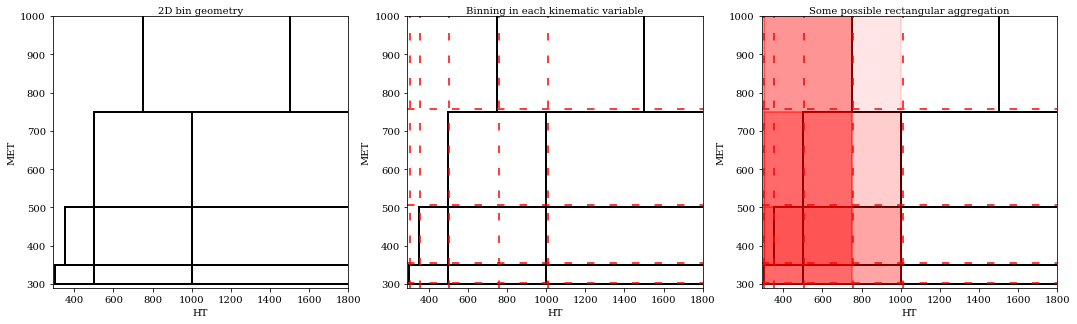

In [47]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
labels = ['2D bin geometry','Binning in each kinematic variable','Some possible rectangular aggregation']

for nn,ax1 in enumerate(axes):
    ax1.set_xlim(290,1800)
    ax1.set_ylim(290,1000)
    ax1.set_xlabel(plot_vars[0])
    ax1.set_ylabel(plot_vars[1])

    for LL,UR in zip(llgrid_list,urgrid_list):
        ax1.add_patch(rectangle(LL,UR))

    if nn>=1:
        for sx,sy in zip(seps[0],seps[1]):
            ax1.axvline(1.01*sx,color='r', dashes=[5, 10])
            ax1.axhline(1.01*sy,color='r',dashes=[5, 10])
# overlap different rectangular aggregations
    if nn>=2:
        for LL,UR in zip(llra_list,urra_list)[20:35]:
            ax1.add_patch(rectangle(LL,UR,edgecolor='r',facecolor='r',alpha=0.1))
    an = ax1.annotate(labels[nn],xy=(.5, 1.01), xycoords='axes fraction',horizontalalignment='center')

# fig.show()

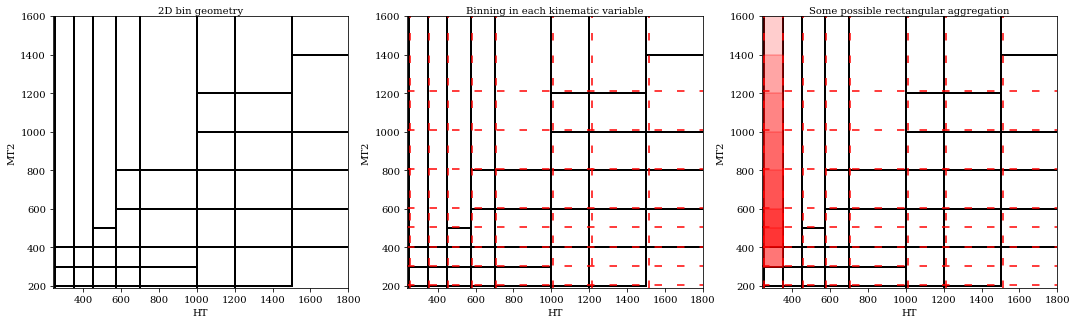

In [19]:
fig, axes = plt.subplots(1,3,figsize=(18,5))
labels = ['2D bin geometry','Binning in each kinematic variable','Some possible rectangular aggregation']

for nn,ax1 in enumerate(axes):
    ax1.set_xlim(240,1800)
    ax1.set_ylim(190,1600)
    ax1.set_xlabel(plot_vars[0])
    ax1.set_ylabel(plot_vars[1])

    for LL,UR in zip(llgrid_list,urgrid_list):
        ax1.add_patch(rectangle(LL,UR))

    if nn>=1:
        for sx,sy in zip(seps[0],seps[1]):
            ax1.axvline(1.01*sx,color='r', dashes=[5, 10])
            ax1.axhline(1.01*sy,color='r',dashes=[5, 10])
# overlap different rectangular aggregations
    if nn>=2:
        for LL,UR in zip(llra_list,urra_list)[20:35]:
            ax1.add_patch(rectangle(LL,UR,edgecolor='r',facecolor='r',alpha=0.1))
    an = ax1.annotate(labels[nn],xy=(.5, 1.01), xycoords='axes fraction',horizontalalignment='center')

# fig.show()

We will now make an animation that shows how we pick all possible aggregations in this 2D projection.

In [20]:
from matplotlib import animation, rc
from IPython.display import HTML

In [69]:
flag_red_background = not True
# save individual frames as png
flag_save_frames = False

fig, ax1 = plt.subplots()
fig.set_tight_layout(True)
ax1.set_xlim(290,1800)
ax1.set_ylim(290,1000)
ax1.set_xlabel(plot_vars[0])
ax1.set_ylabel(plot_vars[1])

LL,UR = zip(llra_list,urra_list)[0]
patch = rectangle(LL,UR, linewidth=3,edgecolor=(0,0,1,1),facecolor=(0,1,0,0.1),zorder=10)

an = ax1.annotate('',xy=(.0, 1.01), xycoords='axes fraction',horizontalalignment='left')
an.set_animated(True)

def init():
    # draw grid
    for LL,UR in zip(llgrid_list,urgrid_list):
        ax1.add_patch(rectangle(LL,UR,zorder=2))
    for sx,sy in zip(seps[0],seps[1]):
        ax1.axvline(1.01*sx,color='r', dashes=[5, 10])
        ax1.axhline(1.01*sy,color='r',dashes=[5, 10])
    ax1.add_patch(patch)
    an.set_text('')
    return ax1, an


def update(i):
    if flag_red_background and i>=1:
        for LL,UR in zip(llra_list,urra_list)[:i-1]:
            ax1.add_patch(rectangle(LL,UR,edgecolor='r',facecolor='r',alpha=0.05,zorder=1))
    LL,UR = zip(llra_list,urra_list)[i]
    patch.set_width(UR[0]-LL[0])
    patch.set_height(UR[1]-LL[1])
    patch.set_xy(LL)
    
    srs=str(ra.makeRA(plotRAs_def[i]))
    an.set_text("Bins in RA: "+srs)
    if flag_save_frames: fig.savefig('plots/animation_frames/RA_scan2d_'+str(i)+".png")

    
    return ax1, an
# NB here I cycle on half of the RAs (len(urra_list)/2),
# otherwise it takes too long to display the plots
anim = animation.FuncAnimation(fig, update,init_func=init, frames=range(0, len(urra_list)/2),
                               interval=300, repeat= not flag_save_frames)
plt.close()

In [55]:
flag_red_background = not True
# save individual frames as png
flag_save_frames = False

fig, ax1 = plt.subplots()
fig.set_tight_layout(True)
ax1.set_xlim(220,1800)
ax1.set_ylim(170,1600)
ax1.set_xlabel(plot_vars[0])
ax1.set_ylabel(plot_vars[1])

LL,UR = zip(llra_list,urra_list)[0]
patch = rectangle(LL,UR, linewidth=3,edgecolor=(0,0,1,1),facecolor=(0,1,0,0.1),zorder=10)

an = ax1.annotate('',xy=(.0, 1.01), xycoords='axes fraction',horizontalalignment='left')
an.set_animated(True)

def init():
    # draw grid
    for LL,UR in zip(llgrid_list,urgrid_list):
        ax1.add_patch(rectangle(LL,UR,zorder=2))
    for sx,sy in zip(seps[0],seps[1]):
        ax1.axvline(1.01*sx,color='r', dashes=[5, 10],lw=1)
        ax1.axhline(1.01*sy,color='r',dashes=[5, 10],lw=1)
    ax1.add_patch(patch)
    an.set_text('')
    return ax1, an


def update(i):
    if flag_red_background and i>=1:
        for LL,UR in zip(llra_list,urra_list)[:i-1]:
            ax1.add_patch(rectangle(LL,UR,edgecolor='r',facecolor='r',alpha=0.05,zorder=1))
    LL,UR = zip(llra_list,urra_list)[i]
    patch.set_width(UR[0]-LL[0])
    patch.set_height(UR[1]-LL[1])
    patch.set_xy(LL)
    
    srs=str(ra.makeRA(plotRAs_def[i]))
    an.set_text("Bins in RA: "+srs)
    if flag_save_frames: fig.savefig('plots/animation_frames/RA_scan2d_'+str(i)+".png")

    
    return ax1, an
# NB here I cycle on half of the RAs (len(urra_list)/2),
# otherwise it takes too long to display the plots
anim = animation.FuncAnimation(fig, update,init_func=init, frames=range(0, 100)+range(1500, 1600),
                               interval=80, repeat= not flag_save_frames)
plt.close()

In [56]:
HTML(anim.to_jshtml())

In [59]:
### this can be saved to a .gif. One needs to install imagemagick, for example
# !brew install imagemagick # on a mac
# !sudo apt-get install imagemagick  # on ubuntu/linux
# anim.save('plots/CMS033_RA_scan2d.gif',writer='imagemagick',dpi=72)
anim.save('plots/CMS036_RA_scan2d.gif',writer='imagemagick',dpi=72)

One can also make the same plots showing the significance of each bin/aggregation (This could be slower as the numerical calculation takes time - to speed it up, I look up the significance from the already-computed list of significances). A BSM signal would then appear as multiple nearby bins all having upward fluctuations.

We here make 3 plots, in the same 2D projection but fixing $N_j,N_b$ to different values. This shows some of the clusters that were found above

In [18]:
# cols0 = plt.get_cmap('RdYlBu')(np.arange(plt.get_cmap('RdYlBu').N))
# cmap_temp = mpl.colors.ListedColormap(cols0)
#temperature map, with middle of range effectively transparent
cols = plt.get_cmap('RdYlBu')(np.arange(plt.get_cmap('RdYlBu').N))
cols[:,-1] = abs(1-2*np.linspace(0, 1, len(cols)))
cmap_temp_alpha = mpl.colors.ListedColormap(cols)

def colsigma(N,cmap='RdYlBu',max=3):
    return plt.get_cmap(cmap)(-N/2/max+0.5)

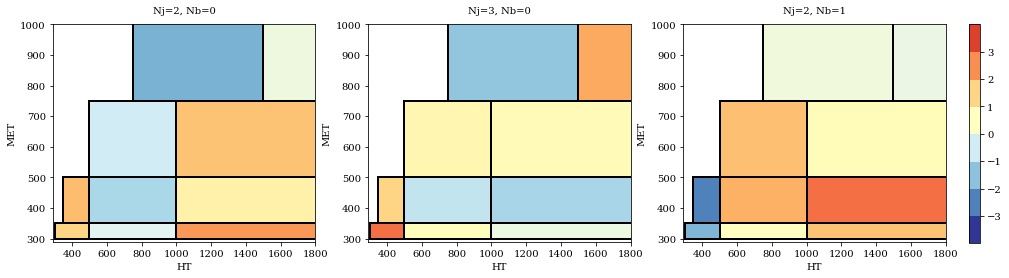

In [97]:
fig, axes = plt.subplots(1,3,figsize=(16,4))

fix_values_list = [[2,0],[3,0],[2,1]]
for nn,ax1 in enumerate(axes):
    ax1.set_xlim(290,1800)
    ax1.set_ylim(290,1000)
    ax1.set_xlabel(plot_vars[0])
    ax1.set_ylabel(plot_vars[1])

    fix_values = fix_values_list[nn]
    extra_ra_def = [ [fix_vars[i],[fix_values[i],fix_values[i]]] for i in range(len(fix_vars))]
    plot_srs = []
    for LL,UR in zip(llgrid_list,urgrid_list):
        bb = rectangle_to_bins(LL,UR,extra_ra_def)
        if bb not in plot_srs and len(bb)==1: plot_srs.append(rectangle_to_bins(LL,UR,extra_ra_def))
    #bin_proj = [ [[d[0][1]],[map(ra.getn,d[1][kin_vars.index(v)][1:]) for v in plot_vars]] for d in dictionary if [d[0][1]] in plot_srs]
    
    for LL,UR in zip(llgrid_list,urgrid_list):
        ax1.add_patch(rectangle(LL,UR))

#     for sx,sy in zip(seps[0],seps[1]):
#         ax1.axvline(1.01*sx,color='r', dashes=[5, 10])
#         ax1.axhline(1.01*sy,color='r',dashes=[5, 10])
    for SR in plot_srs:
        SRdef = dictionary[SR[0]]
        LL,UR = [SRdef[kv][0] for kv in plot_vars], [SRdef[kv][1] for kv in plot_vars]
        try: 
            Nsigma = [RA_sigma[1] for RA_sigma in single_bin_sigma if RA_sigma[0]==SR][0]
        except:
            llres = find_q0_ASR(SR)
            Nsigma = findsigmaq0_signed(llres[1][1],llres[1][3],llres[1][2])
        ax1.add_patch(rectangle(LL,UR,facecolor=colsigma(Nsigma[1]) ) )
    an = ax1.annotate(', '.join(['='.join(z) for z in zip(fix_vars, map(str,fix_values))]),
                      xy=(.5, 1.05), xycoords='axes fraction',horizontalalignment='center')

cax = fig.add_axes([.92, 0.12, 0.01, 0.76])
bounds = np.arange(-4,4.5,1)
cb2 = mpl.colorbar.ColorbarBase(cax, cmap=plt.get_cmap('RdYlBu'), values=-bounds, boundaries=bounds, ticks=bounds[1:-1])

# miscellanous <a class="anchor" id="misc"></a>

Find upper limit on number of signal events for each SR (assuming signal only populates that bin).  
The test statistics used is similar to the one defined above, except that the null hypothesis that we want to exclude is now the BSM signal. So we compute the test statistic $q_\mu$, and we scan $\mu$ until we find 
$$
\mu=\mu_{max} \ | \ q_{\mu_{max}} = 4 
$$
which gives a 95% CL upper limit (2$\sigma$).

In [98]:
def find_mumax(muhat, LLmuhat, LL_0, NsigmaCL=4, verbose=False):
    n = 0
    murange_found = min_found = not True
    func_vec = [[0,LL_0],[muhat, LLmuhat]]    #output vector - start with LL0, LL1, LLmuhat
    mumin = muhat if muhat>0  else 0.
    LL_use = LLmuhat if muhat>0  else LL_0
    mumax = max(1,10*abs(muhat)) # arbitrary but seems to work most of the times
    # range explorer: make sure I am not below mumax that I want to find
    while not murange_found:
        mu_use = (mumax+mumin)/2.
        LL_found = q0.runmin_err(mu_use,True)[1]
        if verbose: print " %1.2f" % mumax," %1.2f" % LL_found," %1.2f" %  (LL_found - LLmuhat)
        if LL_found - LL_use - NsigmaCL < 0: # if below mumax
            mumax = 2*mumax
        else: murange_found = True
    # min explorer: bisect interval to find LL-LL0=4
    if verbose: print "n   mu   LL(mu)  LL(mu)-LLhat"
    while not min_found:
        n=n+1
        #call minuit for given mu
        LL_found = q0.runmin_err(mu_use,True)[1]
        if verbose: print n, " %1.2f" % mu_use," %1.2f" % LL_found," %1.2f" %  (LL_found - LLmuhat)
        if abs(LL_found - LL_use - NsigmaCL)>0.1:
            if LL_found - LL_use - NsigmaCL < 0: # 
                mumin, mumax = mu_use, mumax
            else: mumin, mumax = mumin, mu_use # 
            mu_use = (mumax+mumin)/2.
        else: min_found = True
        func_vec.append([mu_use,LL_found])
        # print " %1.2f" % mumin," %1.2f" % mumax," %1.2f" % mu_use
    return (func_vec,n)

def find_95CL_upper_lim(ASR, verbose=False):
    # load even counts for that search
    [obs, back, covV ] =  q0.aggregate(ASR)
    sig = [0] * len(obs)
    # new physics always adds events, but here we also look at deficits, so it could be <0
    # signal events in ASR: this is a first guess (obs-bg), the cross section multiplier is variable in the minimization
    sig[0] = abs((obs[0] - back[0]))
    sig[0] = sig[0] if sig[0]>1 else 1.
    q0.setSig(np.array(sig))

    # find global minimum
    [ muhat, LLhat, theta_vec_hat, postfit_err_vec_hat ] = q0.runmin_err(1.0,False)
    [ mu0, LL_0, theta_vec_0, postfit_err_vec_0 ] = q0.runmin_err(0.0,True)
    
    # the global minimum cannot be lower than the SM minimum: sometimes minuit gets stuck, usually at large values of signal counts
    # recompute up to 10 times rescaling down signal, otherwise give up :(
    mutry, n_try = 1., 0
    while ( LLhat > LL_0 + 0.01 and n_try < 10):
        n_try += 1
        mutry = mutry/n_try
        [ muhat, LLhat, theta_vec_hat, postfit_err_vec_hat ] = q0.runmin_err(mutry,False)    
    
    mumax_vec, n_mumax = find_mumax(muhat, LLhat, LL_0, NsigmaCL=4, verbose=verbose)
    
    return (sig[0]*mumax_vec[-1][0], mumax_vec[-1][1])


In [102]:
single_bin_95CL_max = [find_95CL_upper_lim([SR])[0] for SR in binlist]

In [106]:
#plt.semilogy(single_bin_95CL_max)

In [107]:
np.around(single_bin_95CL_max, decimals=2)
# np.savetxt('CMS033_bin_95CL_upper_lim.dat',np.around(single_bin_95CL_max, decimals=2).tolist(), fmt="%.2f")

array([ 1206.23,   102.07,    46.39,   826.26,   121.37,    36.12,
         172.38,    36.95,    35.88,     8.99,   119.92,    47.99,
          14.11,    67.46,   103.06,    23.26,    81.96,    13.88,
          13.25,     3.43,    54.05,    10.56,     1.97,    37.37,
          11.52,     5.84,     9.13,     2.01,     7.76,     2.05,
        1084.04,   300.9 ,    47.65,   513.73,   228.66,    38.24,
         244.78,    50.6 ,    38.23,    28.76,   158.69,   172.62,
          39.58,    87.23,   226.51,    45.28,    65.13,    16.7 ,
          28.07,     7.97,    90.28,    33.26,    15.03,    71.81,
          68.13,    20.52,    16.78,    12.15,     3.91,     3.63,
          18.41,    18.07,     8.96,     7.64,    21.72,    10.21,
           1.98,     6.03,     4.37,     2.05,   161.17,   149.5 ,
          33.01,   144.83,   152.75,    29.66,    61.44,    23.59,
          34.59,    11.66,   115.09,    52.85,    31.62,    53.29,
          78.87,    37.13,    30.4 ,    12.66,     6.1 ,     5